# Replication file for 'The Intertemporal Keynesian Cross'
### Part III:  quantitative environment (sections 6 and 7)

Adrien Auclert, Matthew Rognlie, Ludwig Straub

April 2024

In [1]:
import numpy as np
from scipy import optimize
import json

In [2]:
import sequence_jacobian as sj  
import calibration
from models import models_analytical, models_heterogeneous
from aux_fiscal import Bplan, compute_multipliers
import winding_number
import plotting.sec67_plots as plots

opts = {'texfig': True, 'savefig': True}

## Setup: load non-household blocks

First, we define simple blocks that characterize fiscal and monetary policy, along with wage inflation and ex-post returns:

In [3]:
@sj.simple
def fiscal(B, r, G, w, N):
    T = (1 + r(-1)) * B(-1) + G - B # taxes
    Z = w*N - T # after-tax income
    return T, Z

@sj.simple
def wage_inflation(pi, w):
    piw = (1 + pi) * w / w(-1) - 1
    return piw

@sj.simple
def union(piw, N, UCE, Z, kappaw, vphi, frisch, muw, beta, theta):
    wnkpc = (kappaw * (muw * vphi * N ** (1 / frisch)/(UCE * (1-theta)*Z/N) - 1) +
             beta * piw(+1)*(1 + piw(+1)) - piw*(1 + piw))
    return wnkpc

@sj.simple
def taylor(r, pi, phi_pi):
    i = r.ss + phi_pi * pi
    return i

@sj.simple
def share_bond(B, J_end_period):
    bondshare = B / ( B + J_end_period)
    return bondshare

@sj.simple
def finance(r, J, J_end_period, bondshare, i, pi):
    rpost = bondshare(-1) * (1+r(-1)) + (1 - bondshare(-1)) * J/J_end_period(-1) - 1
    fisher = 1 + i - (1 + r) * (1 + pi(+1))
    return rpost, fisher

@sj.simple
def mkt_clearing(A, B, J_end_period, C, I, G, p_adjust, k_adjust, Y):
    asset_mkt = A - B - J_end_period
    goods_mkt = C + I + G + p_adjust + k_adjust - Y
    return asset_mkt, goods_mkt

Next, we load a block that characterizes production and pricesetting:

In [4]:
from capital_sticky_prices import production_pricesetting
other_blocks = [fiscal, wage_inflation, union, taylor, production_pricesetting, share_bond, finance, mkt_clearing]

## Setup: load household blocks

In [5]:
with open('solved_params.json', 'r') as f:
    params = json.load(f)

In [6]:
hh_analytical, ss_analytical = models_analytical.get_all_quant(params)
hh_het, ss_het = models_heterogeneous.get_all_quant(params)
hh_all = {**hh_analytical, **hh_het}
ss_all = {**ss_analytical, **ss_het}
hh_names = {m: hh_all[m].name for m in hh_all}

Now we'll back out what the vphi in preferences needs to be by inverting the equation for zero wage inflation in steady state:

In [7]:
calib = calibration.get_calibration_quant()
muw, N, frisch, theta, Z = [calib[k] for k in ('muw', 'N', 'frisch', 'theta', 'Z')]
vphi_base = (1-theta)*Z/N**(1+1/frisch)/muw
for m in ss_all:
    ss_all[m]['vphi'] = vphi_base*ss_all[m]['UCE']

## Setup: obtain steady states for all models
This involves a little bit of unnecessary redundancy since it's evaluating the household steady states again:

In [8]:
models_all = {m: sj.combine([*other_blocks, hh_all[m]]) for m in hh_all}
for m in models_all:
    if m in ('RA', 'TA'):
        ss_all[m] = models_all[m].steady_state({**ss_all[m], **calib}, dissolve=[f'hh_{m.lower()}'])
    else:
        ss_all[m] = models_all[m].steady_state({**ss_all[m], **calib})

Test to ensure that all steady-state targets are equal to zero:

In [9]:
for m in models_all:
    for k in ('wnkpc', 'pi', 'piw', 'fisher', 'asset_mkt'):
        assert np.isclose(ss_all[m][k], 0)
    assert np.isclose(ss_all[m]['goods_mkt'], 0, atol=1E-5) # less exact for HA-two

## Table 3: Calibration

In [10]:
plots.table3({**calib, 'rhoG': calibration.rhoG, 'rhoB': calibration.rhoB})

Capital share:                            0.294  
Gov spending to GDP:                      0.2  
Debt to GDP:                              0.7  
Capital to GDP:                           2.26  
SS price markup:                          1.0  
SS wage markup:                           1.0  
Depreciation rate:                        0.08  
Frisch elasticity of labor supply:        1  
Investment elasticity to q:               4  
Price flexibility:                        0.23  
Wage flexibility:                         0.03  
Taylor rule coefficient:                  1.5  
Persistence of gov spending:              0.76  
Persistence of debt:                      0.93  


## Final setup: precompute household Jacobians for all models

This will make it easy to recompute as we change the general equilibrium environment.

In [11]:
T = 500
Js_cache = {m: hh_all[m].partial_jacobians(ss_all[m], inputs=['Z', 'rpost'], outputs=['C', 'A', 'UCE'], T=T) for m in models_all}
Js = {m: hh_all[m].jacobian(ss_all[m], inputs=['Z', 'rpost'], outputs=['C', 'A'], T=T, Js=Js_cache[m]) for m in models_all}

We can check the numerical Jacobians we calculate for BU and TABU against our analytical Jacobian formulas to ensure they are the same (away from the truncation boundary, where the numerical Jacobians have some artifacts).

We cannot do this for RA and TA, since the procedure underlying the numerical Jacobians assumes a return to steady state—which will occur in general equilibrium, but not in partial equilibrium due to the unit root in saving from an income shock:

In [12]:
Ms_analytical, As_analytical = models_analytical.MA_all(params, calib['r'], T)
for m in ('BU', 'TABU'):
    assert np.allclose(Js[m]['C', 'Z'][:-50, :-50], Ms_analytical[m][:-50, :-50])
    assert np.allclose(Js[m]['A', 'Z'][:-50, :-50], As_analytical[m][:-50, :-50])

## Figure 7

In [13]:
mcap = {m: Js[m]['C', 'rpost'][:, 0] / calib['A'] for m in Js}
mcap['RA'] = mcap['TA'] = Ms_analytical['RA'][:, 0] # numerical Jacobian misses unit root

mlab = {m: np.abs(Js[m]['C', 'Z'][:, 0]) for m in Js}
mlab['RA'] = Ms_analytical['RA'][:, 0]
mlab['TA'] = Ms_analytical['TA'][:, 0]

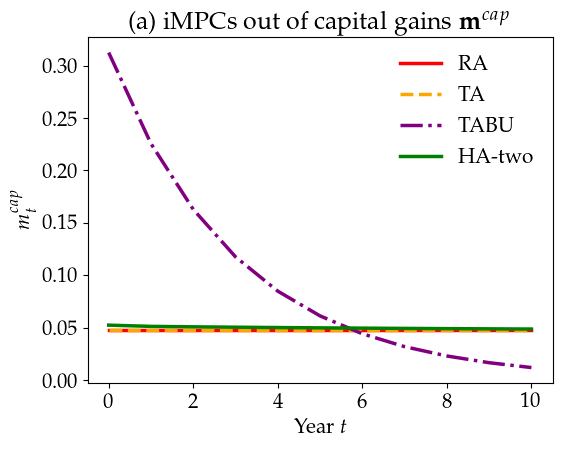

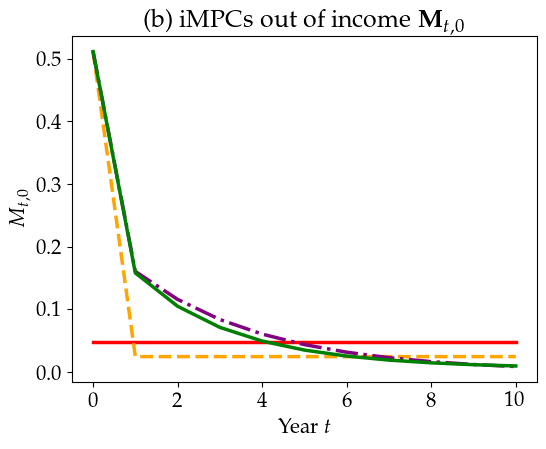

In [14]:
plots.figure7(mcap, mlab, **opts)

# Calculating multipliers
Calculate general equilibrium Jacobians for our models in response to shocks to $B$ and $G$. (This is a bit brute-force.)

In [15]:
# specify unknowns to solve for and GE targets on DAG to hit
unknowns = ['Y', 'w', 'r']
targets = ['asset_mkt', 'wnkpc', 'fisher']
inputs = ['B', 'G']
outputs = ['C', 'I', 'N', 'pi', 'Y', 'r', 'Z', 'rpost']

Gs = {m: models_all[m].solve_jacobian(ss_all[m], unknowns, targets, inputs, outputs, T=T, Js=Js_cache[m]) for m in models_all}

## Figure 8

In [16]:
rhoG = 0.76
rhoB = 0.93

dG = rhoG**np.arange(T)
dB = Bplan(dG, rhoB)
shock = {'G': dG, 'B': dB}

impulses = {m: Gs[m] @ shock for m in ('HA-two', 'RA', 'TA', 'TABU')}

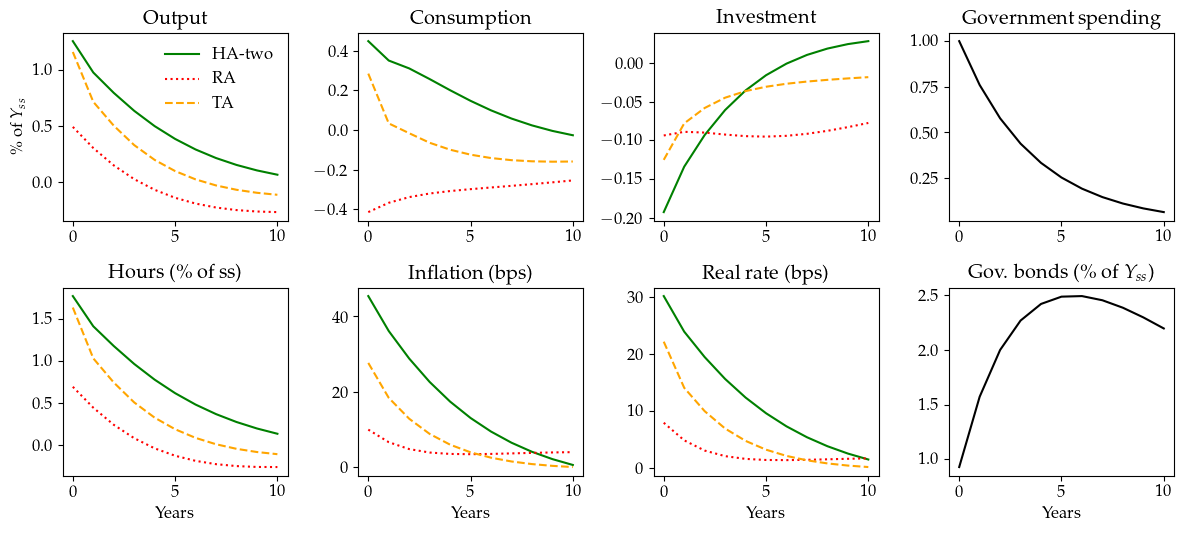

In [17]:
plots.figure8(impulses, **opts)

## Figure 10 decomposition
Now for HA-two and TABU, given the same shock, we look at what part of the household consumption impulse response is attributable to changes in income (`Z`), capital gains (`rpost` at date 0, changes in which correspond to a surprise capital gain), and rates (`rpost` at date 1 onward).

In [18]:
decomp = {}
for m in ('HA-two', 'TABU'):
    # load impulse responses that are outputs or inputs to the household
    dC, dZ = impulses[m]['C'], impulses[m]['Z']
    dcap = impulses[m]['rpost']*(np.arange(T) == 0) # change from cap gain: only rpost_0
    dr = impulses[m]['rpost']*(np.arange(T) != 0)   # change from r: everything except rpost_0

    # now store the contributions from each component, check that they sum to dC
    decomp[m] = {}
    for dx, name, i in zip((dZ, dcap, dr), ('Income', 'Capital gain', 'Rate'), ('Z', 'rpost', 'rpost')):
        decomp[m][name] = Js[m]['C', i] @ dx

    assert np.allclose(sum(decomp[m][x] for x in decomp[m]), dC)
    decomp[m] = {'Overall': dC, **decomp[m]}
    

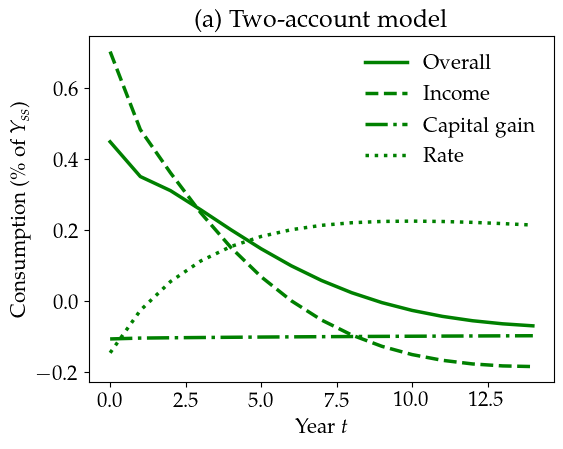

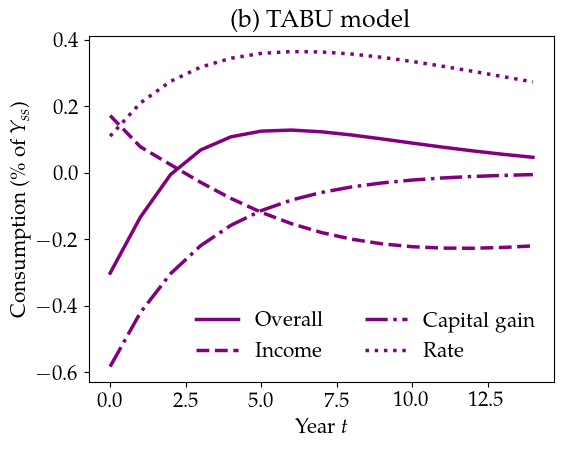

In [19]:
plots.figure10(decomp, **opts)

## Figures G.1 and G.2

In [20]:
rho_Bs_short = [0, 0.5, 0.76, 0.93]
rho_Bs_labels = [rf'$\rho_B = {rho_B}$' for rho_B in rho_Bs_short]

First Figure G.1, giving HA-two for different $\rho_B$:

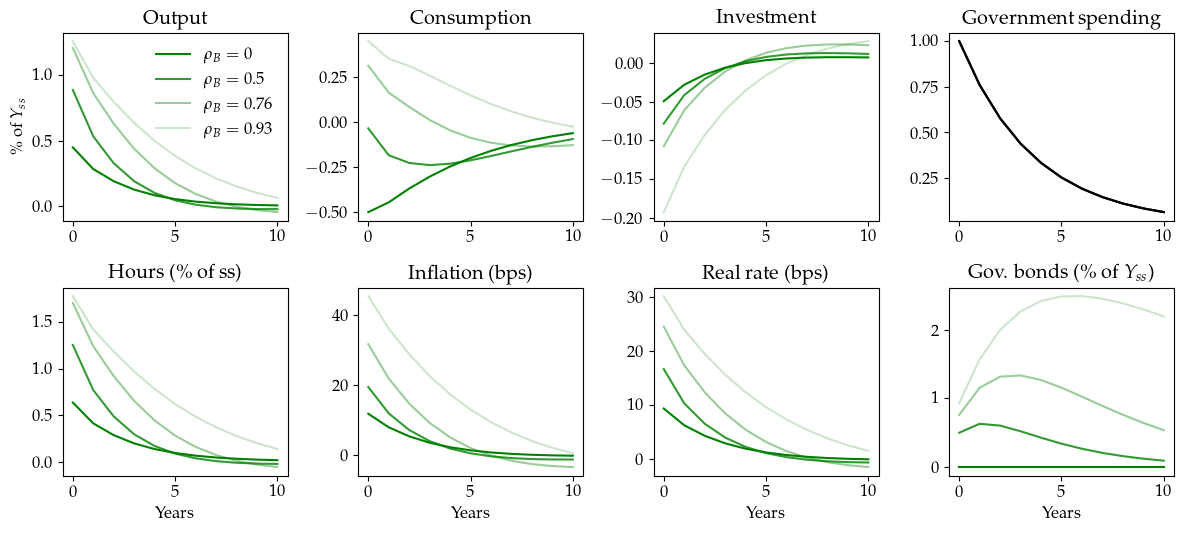

In [21]:
impulses = {}
for rhoB, label in zip(rho_Bs_short, rho_Bs_labels):
    dB = Bplan(dG, rhoB)
    shock = {'G': dG, 'B': dB}
    impulses[label] = Gs['HA-two'] @ shock
plots.figureG(impulses, 'green', '1', **opts)

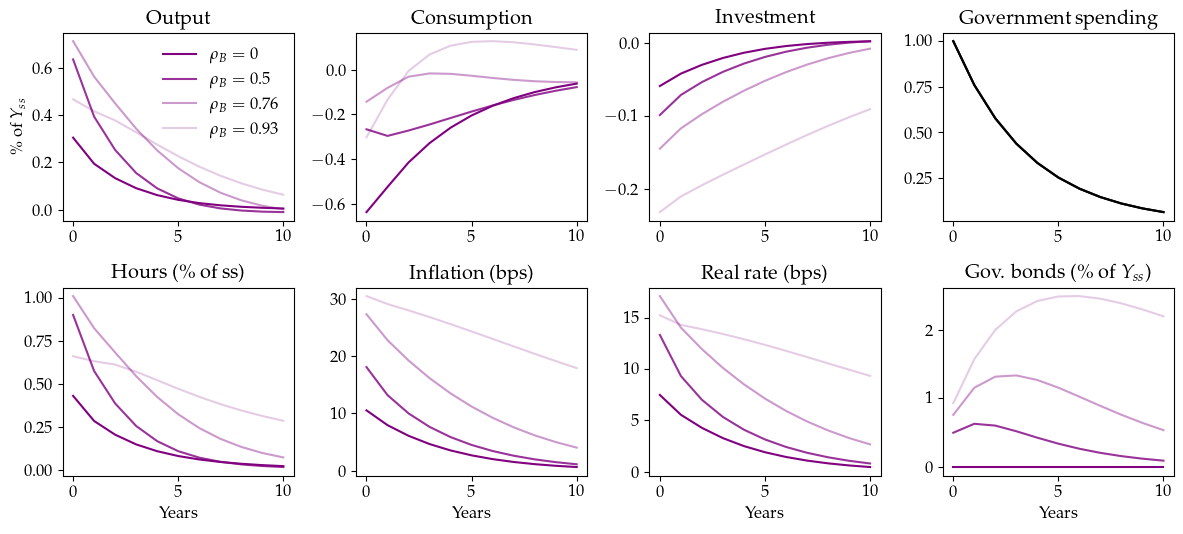

In [22]:
impulses = {}
for rhoB, label in zip(rho_Bs_short, rho_Bs_labels):
    dB = Bplan(dG, rhoB)
    shock = {'G': dG, 'B': dB}
    impulses[label] = Gs['TABU'] @ shock
plots.figureG(impulses, 'purple', '2', **opts)

## Figure 9

In [23]:
NrhoB = 20
rho_Bs = np.linspace(0, 0.93, NrhoB)
mult_impact, mult_cumul = {}, {}
for m in ('TABU', 'HA-two', 'RA', 'TA'):
    mult_impact[m], mult_cumul[m] = np.empty(NrhoB), np.empty(NrhoB)
    G_Y = Gs[m][['Y'], :] # only interested in multiplier on output here
    for i, rhoB in enumerate(rho_Bs):
        dB = Bplan(dG, rhoB)
        shock = {'G': dG, 'B': dB}
        dY = (G_Y @ shock)['Y']
        mult_impact[m][i], _, mult_cumul[m][i] = compute_multipliers(dY, dG, calib['r'])

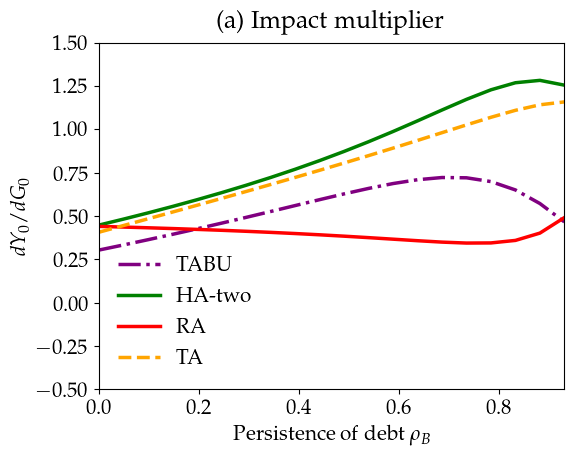

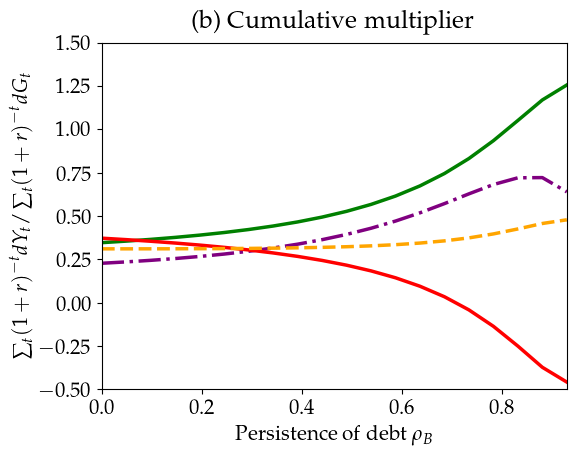

In [24]:
plots.figure9(rho_Bs, mult_impact, mult_cumul, **opts)

## Table 4, multipliers for quantitative environment

In [25]:
plots.table4(mult_impact, mult_cumul, ikc=False).round(1)

,RA,TA,TABU,HA-two
BB impact,0.4,0.4,0.3,0.4
BB cumulative,0.4,0.3,0.2,0.3
DF impact,0.5,1.2,0.5,1.3
DF cumulative,-0.5,0.5,0.6,1.3


## Figures G.3 through G.6
#### Figure G.3

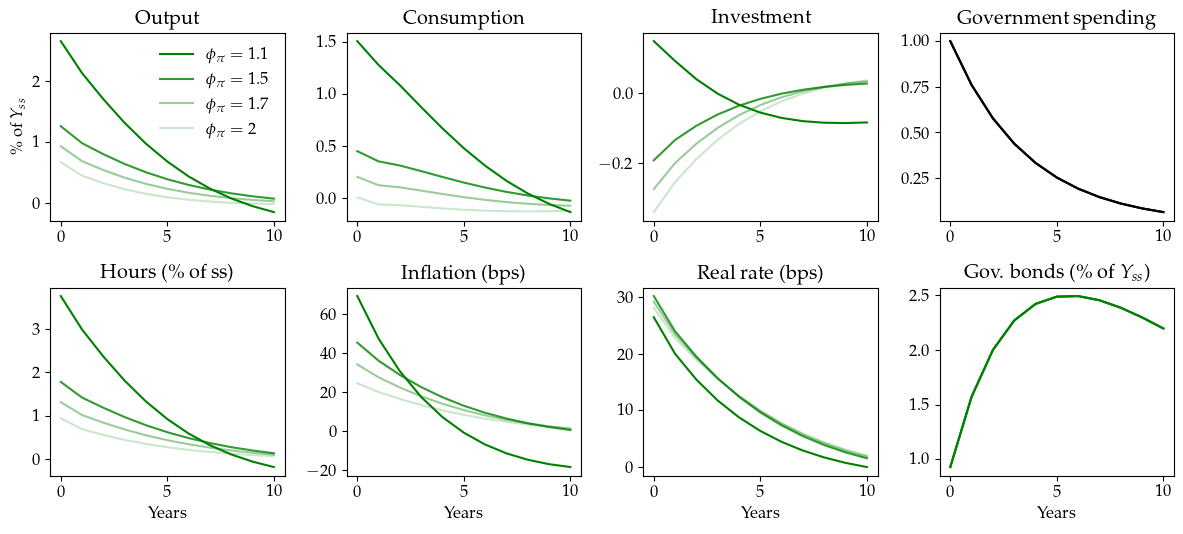

In [26]:
dB = Bplan(dG, 0.93)
shock = {'G': dG, 'B': dB}
phi_pis = [1.1, 1.5, 1.7, 2]
phi_pi_labels = [rf'$\phi_\pi = {phi_pi}$' for phi_pi in phi_pis]
outputs=['C', 'I', 'N', 'pi', 'Y', 'r']

impulses = {}
for phi_pi, label in zip(phi_pis, phi_pi_labels):
    ss_alt = ss_all['HA-two'].copy()
    ss_alt['phi_pi'] = phi_pi
    impulses[label] = models_all['HA-two'].solve_jacobian(ss_alt, unknowns, targets, inputs, outputs, T=T, Js=Js_cache['HA-two']) @ shock

plots.figureG(impulses, 'green', '3', **opts)

#### Figure G.4

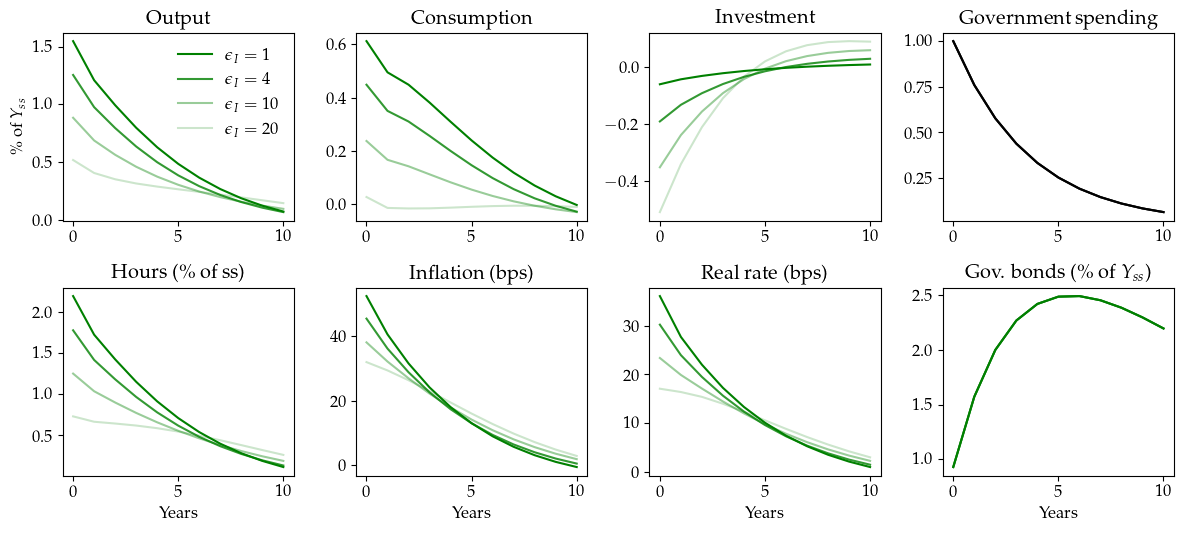

In [27]:
eps_Is = [1, 4, 10, 20]
eps_I_labels = [rf'$\epsilon_I = {eps_I}$' for eps_I in eps_Is]

impulses = {}
for eps_I, label in zip(eps_Is, eps_I_labels):
    ss_alt = ss_all['HA-two'].copy()
    ss_alt['epsI'] = eps_I
    impulses[label] = models_all['HA-two'].solve_jacobian(ss_alt, unknowns, targets, inputs, outputs, T=T, Js=Js_cache['HA-two']) @ shock

plots.figureG(impulses, 'green', '4', **opts)

#### Figure G.5

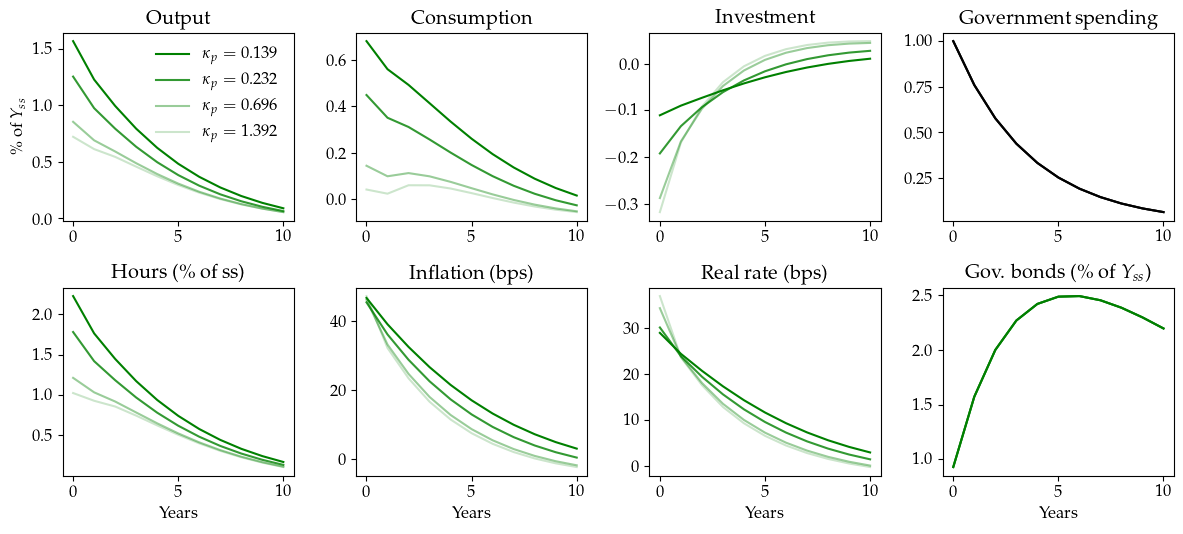

In [28]:
kappa_ps = [calib['kappap']*6 / (1 + Gammap) for Gammap in (9, 5, 1, 0)]
kappa_p_labels = [rf'$\kappa_p = {kappa_p:.3f}$' for kappa_p in kappa_ps]

impulses = {}
for kappa_p, label in zip(kappa_ps, kappa_p_labels):
    ss_alt = ss_all['HA-two'].copy()
    ss_alt['kappap'] = kappa_p
    impulses[label] = models_all['HA-two'].solve_jacobian(ss_alt, unknowns, targets, inputs, outputs, T=T, Js=Js_cache['HA-two']) @ shock

plots.figureG(impulses, 'green', '5', **opts)

#### Figure G.6

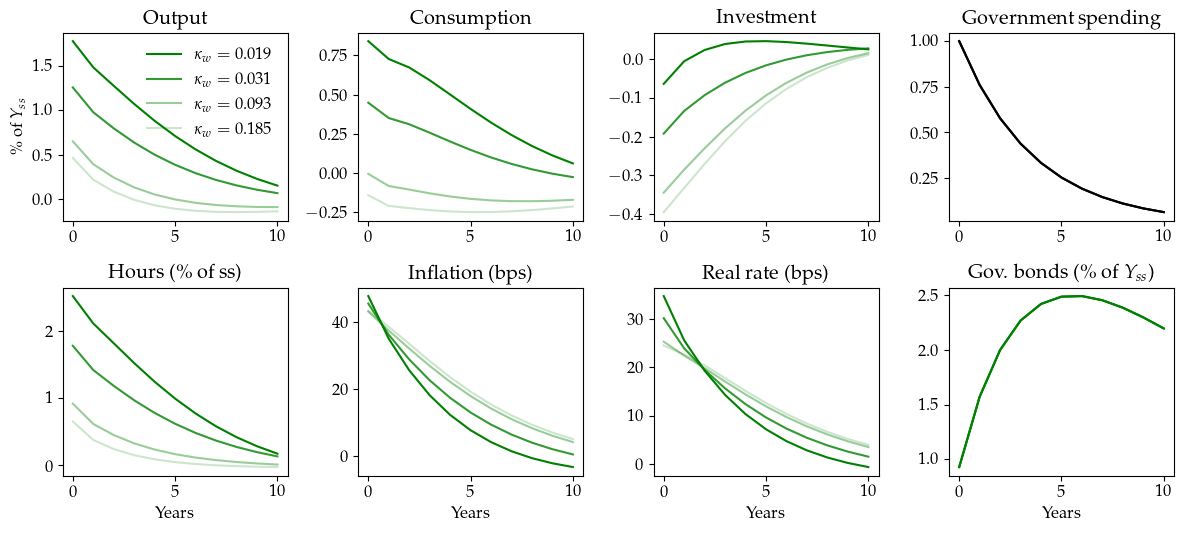

In [29]:
kappa_ws = [calib['kappaw']*6 / (1 + Gammap) for Gammap in (9, 5, 1, 0)]
kappa_w_labels = [rf'$\kappa_w = {kappa_w:.3f}$' for kappa_w in kappa_ws]

impulses = {}
for kappa_w, label in zip(kappa_ws, kappa_w_labels):
    ss_alt = ss_all['HA-two'].copy()
    ss_alt['kappaw'] = kappa_w
    impulses[label] = models_all['HA-two'].solve_jacobian(ss_alt, unknowns, targets, inputs, outputs, T=T, Js=Js_cache['HA-two']) @ shock

plots.figureG(impulses, 'green', '6', **opts)

# Figure 11: different monetary rules
Now we need to change the general equilibrium environment, replacing the Taylor rule with both a constant-$r$ rule and with a constant-$i$ ("ZLB") rule over the first three years.

Recall that the Taylor rule block defined earlier depends on inflation with a slope of $\phi_\pi$, so that it's just a diagonal matrix with $\phi_\pi=1.5$ in every entry:

In [30]:
J_taylor = taylor.jacobian(ss_all['HA-two'], inputs=['pi'], outputs=['i'], T=T)['i', 'pi'].matrix(T)
J_taylor[:5, :5]

array([[1.5, 0. , 0. , 0. , 0. ],
       [0. , 1.5, 0. , 0. , 0. ],
       [0. , 0. , 1.5, 0. , 0. ],
       [0. , 0. , 0. , 1.5, 0. ],
       [0. , 0. , 0. , 0. , 1.5]])

A constant-$r$ rule has $i$ proportionately to tomorrow's inflation instead, so that its Jacobian has entries of $1+r$ above the main diagonal. We specify a Jacobian with this as the first three rows, then reverting to a Taylor rule:

In [31]:
J_constant_r = np.diag(np.full(T-1, 1+calib['r']), 1)
J_constant_r[3:] = J_taylor[3:]

Similarly, we specify a temporary "ZLB" rule where the nominal interest rate does not react for the first three years:

In [32]:
J_zlb = J_taylor.copy()
J_zlb[:3] = 0

Now, we will consider all three possibilities, specified directly as Jacobians, as replacements for our "Taylor" block (there should be no change in the "Taylor" case), and build new models with them:

In [33]:
names = ['Taylor rule', 'Constant-r (3 years)', 'ZLB (3 years)']
models_alt = {}
other_blocks_alt = other_blocks.copy()
for name, Ji in zip(names, (J_taylor, J_constant_r, J_zlb)):
    other_blocks_alt[3] = sj.JacobianDict({'i': {'pi': Ji}}, name='monetary')
    models_alt[name] = sj.combine([*other_blocks_alt, hh_all['HA-two']])

Now solve for `G` general equilibrium outcomes for each:

In [34]:
Gs_alt = {m: models_alt[m].solve_jacobian(ss_all['HA-two'], unknowns, targets, inputs, outputs=['Y'], T=T, Js=Js_cache['HA-two']) for m in models_alt}

And evaluate at our two shocks:

In [35]:
shock = {'G': dG, 'B': Bplan(dG, 0.76)}
dYs_rho_76 = {m: (Gs_alt[m] @ shock)['Y'] for m in models_alt}

shock = {'G': dG, 'B': Bplan(dG, 0.93)}
dYs_rho_93 = {m: (Gs_alt[m] @ shock)['Y'] for m in models_alt}

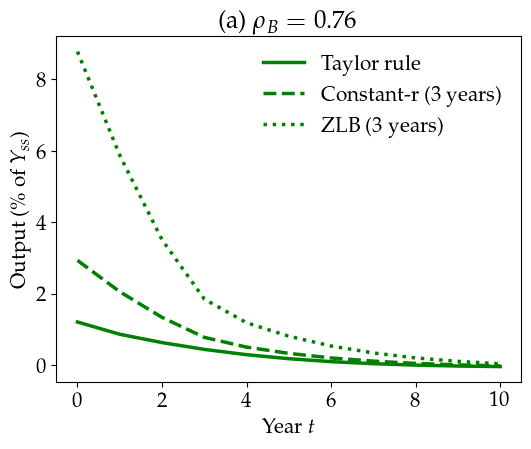

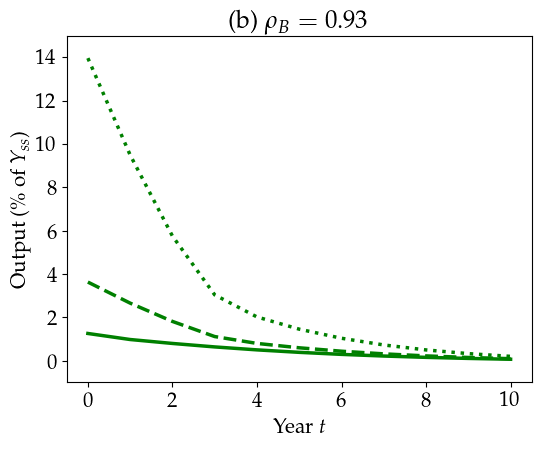

In [36]:
plots.figure11(dYs_rho_76, dYs_rho_93, **opts)

# Determinacy thresholds
We couldn't keep the constant-$r$ or ZLB rules in place forever, because in the quantitative model they are indeterminate. Let's figure out, for each model, at which Taylor rule coefficient $\phi_\pi$ the model becomes indeterminate. (This is referenced in footnote 47 of the paper.)

We can check determinacy for an individual model and $\phi_\pi$ by computing the $\mathbf{H}_\mathbf{U}$ Jacobian mapping unknowns to targets (see the sequence-space Jacobian) paper and applying our winding number test. For instance, the TABU model is determinate at $\phi_\pi=1.2$, since its winding number there is 0, but not at $\phi_\pi=1.0$, since its winding number there is -1:

In [37]:
ss = ss_all['TABU'].copy()
ss['phi_pi'] = 1.2
H_U = models_all['TABU'].jacobian(ss, unknowns, targets, T=T, Js=Js_cache['TABU'])
winding_number.from_H_U(H_U, unknowns, targets)

/opt/miniconda3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
/opt/miniconda3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det


0

In [38]:
ss['phi_pi'] = 1.0
H_U = models_all['TABU'].jacobian(ss, unknowns, targets, T=T, Js=Js_cache['TABU'])
winding_number.from_H_U(H_U, unknowns, targets)

/opt/miniconda3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
/opt/miniconda3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det


-1

It is a bit costly to reevalute the entire Jacobian for each model this way every time we need to test a new $\phi_\pi$. Fortunately, it turns out that the $\phi_\pi$ parameter only affects the `fisher` target (of the three above), and it does so through the term $\phi_\pi \pi$. So, for each model, we'll only go through most of the computation of the Jacobian once, and then manually adjust $\phi_\pi$ when we test determinacy at different points.

In [39]:
for m in ('BU', 'TABU', 'HA-hi-liq', 'HA-two'):
    H_U = models_all[m].jacobian(ss_all[m], unknowns, targets + ['pi'], T=T, Js=Js_cache[m])
    A = winding_number.pack_jacdict_center(H_U, unknowns, targets+['pi'])

    def winding(phi_pi):
        A0 = A[:, :-1, :].copy()                                     # copy everything except pi output
        A0[:, -1, :] += (phi_pi - ss_all[m]['phi_pi']) * A[:, -1, :] # manually correct 'fisher' for phi_pi change
        return winding_number.winding_number(A0)
    
    phi_pi = optimize.bisect(lambda x: winding(x)+0.5, 0.9, 1.2, xtol=1E-5) # where does winding go from -1 to 0?
    print(f'Threshold for {m}: {phi_pi:.2f}')


Threshold for BU: 1.12
Threshold for TABU: 1.09
Threshold for HA-hi-liq: 1.02
Threshold for HA-two: 1.05


# Robustness to alternative portfolios in HA-two (Figure F.1)
Our assumption in the paper is that the liquid and illiquid accounts hold equity and bonds in equal proportions. Alternatively, we can assume that only bonds are held in the liquid account, and that all equity is held in the illiquid account, which we implement below:

In [40]:
ss_two_alt = ss_all['HA-two'].copy()
ss_two_alt['liquidshare'] = ss_two_alt['Aliq'] / ss_two_alt['A']
hh_two_alt = models_heterogeneous.ha_two_alt
model_two_alt = sj.combine([*other_blocks, hh_two_alt])

Now, with this alternative model, look at how MPCs out of capital gains vary:

In [41]:
mcap['HA-two-alt'] = hh_two_alt.jacobian(ss_two_alt, inputs=['rpost'],
                            outputs=['C'], T=25)['C','rpost'][:, 0] / ss_two_alt['A']

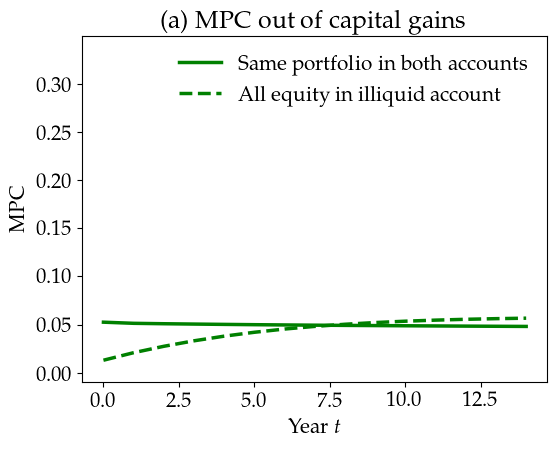

In [42]:
plots.figureF1a(mcap, **opts)

In [43]:
mcap['HA-two-alt'][:10]

array([0.01294815, 0.02078483, 0.02742575, 0.03312585, 0.03795731,
       0.04200269, 0.04535267, 0.04809477, 0.05031437, 0.05209324])

We'll also redo our main analysis for the balanced-budget ($\rho_B=0$) and highly deficit-financed ($\rho_B=0.93$) cases, and compare what we get to the original outcomes to make Figure F.1(b):

In [44]:
G_C_alt = model_two_alt.solve_jacobian(ss_two_alt, unknowns, targets, inputs, ['C'], T=T, Js=Js_cache['HA-two'])
G_C = Gs['HA-two']

In [45]:
shock_bb = {'G': dG, 'B': 0*dG}
shock_df = {'G': dG, 'B': Bplan(dG, 0.93)}

In [46]:
dC_bb = (G_C @ shock_bb)['C']
dC_bb_alt = (G_C_alt @ shock_bb)['C']
dC_df = (G_C @ shock_df)['C']
dC_df_alt = (G_C_alt @ shock_df)['C']

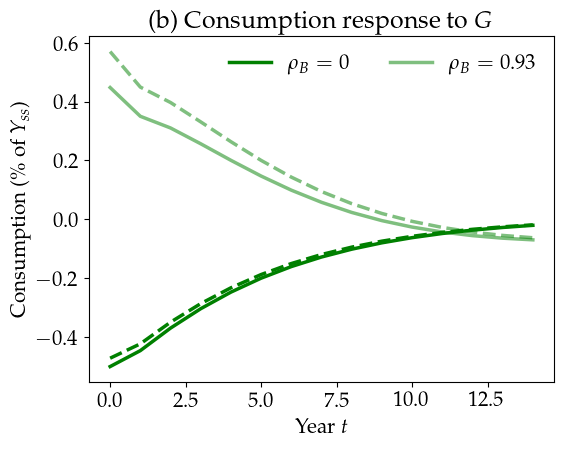

In [47]:
plots.figureF1b(dC_bb, dC_bb_alt, dC_df, dC_df_alt, **opts)